### <p style="color:red;">1.DESCARGA LIBRERÍAS</p> 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#normalización
from sklearn.preprocessing import MinMaxScaler

### <p style="color:red;">2.CARGA DE LOS DATASETS</p>

In [2]:
features_const = pd.read_csv('features_const_PD.csv')

In [3]:
features_explot = pd.read_csv('features_explot_PD.csv')

In [4]:
df_const= pd.read_csv('loan_data_2007_2014.csv')

/tmp/ipykernel_2759/811510779.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_const= pd.read_csv('loan_data_2007_2014.csv')


In [5]:
df_explot= pd.read_csv('loan_data_2015.csv')

/tmp/ipykernel_2759/2731809088.py:1: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_explot= pd.read_csv('loan_data_2015.csv')


Añadimos la variable objetivo al dataset de variables

In [6]:
features_const['loan_status'] = df_const['loan_status']

In [7]:
features_explot['loan_status'] = df_explot['loan_status']

Cambiamos el nombre al dataset con el que vamos a trabajar para no inducir a errores

In [8]:
df_const = features_const
df_explot = features_explot

Echamos un vistazo a las categorías de la variable target

In [9]:
df_const['loan_status'].value_counts()

loan_status
Current                                                211540
Fully Paid                                             177477
Charged Off                                             40614
Late (31-120 days)                                       6487
In Grace Period                                          2981
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1153
Default                                                   780
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

In [10]:
df_explot['loan_status'].value_counts()

loan_status
Current               363103
Fully Paid             20518
Issued                  8460
Late (31-120 days)      4284
In Grace Period         2907
Charged Off             2228
Late (16-30 days)       1029
Default                  360
Name: count, dtype: int64

### <p style="color:red;">3.IDENTIFICACIÓN DE LA POBLACIÓN OBJETIVO</p>

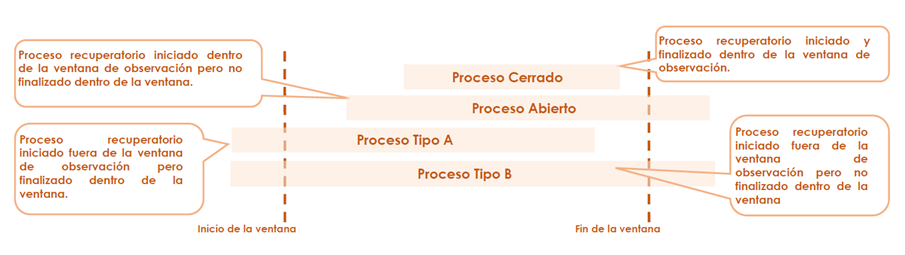

- Los procesos recuperatorios que se tienen en cuenta para la estimación de la LGD, son los procesos cerrados y procesos abiertos (los procesos tipo A y B no se dispone de información suficiente).
- En nuestro dataset disponemos del importe total de las 'recuperaciones' y los 'gastos', por lo que no tenemos que calcularlas.
- Consideraremos **procesos cerrados** aquellos que se encuentran en "Charged Off" y **procesos abiertos** aquellos que se encuentran en "default".

No es necesario que utilicemos las mismas categorías de `loan_status` para la PD como para la LGD, aunque si estamos construyendo un modelo conjunto de PD y LGD (por ejemplo, para la estimación de la Expected Loss), es razonable mantener cierta consistencia en los criterios de selección. Sin embargo, para LGD, es fundamental enfocarse únicamente en los préstamos que han experimentado pérdidas reales, por lo que puede ser necesario filtrar más estrictamente que en PD. Por ello:
- En PD, defines un evento de default potencial o real (usualmente Default y Charged Off, y a veces Late (31-120 days) dependiendo del enfoque.
- Para LGD, solo importa calcular las pérdidas reales de los préstamos con un evento confirmado de default. Aquí generalmente Default y Charged Off son suficientes.

In [11]:
df_const_LGD = df_const[df_const.loan_status.isin(["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"])]

In [12]:
df_const_LGD[["loan_status"]].value_counts()

loan_status                                        
Charged Off                                            40614
Default                                                  780
Does not meet the credit policy. Status:Charged Off      761
Name: count, dtype: int64

Observamos cómo sólo un 1,85% de la muestra de construcción de la LGD son procesos recuperatorios que se encuentran abiertos ("default"). El motivo se debe a que la muestra de construcción abarca desde Enero 2007 hasta Diciembre 2014, por lo que se trata de un periodo lo suficientemente amplio como para que de tiempo a que los procesos recuperatorios se cierren.

In [13]:
(780/df_const_LGD.shape[0])*100

1.8503143162139721

In [14]:
df_explot_LGD = df_explot[df_explot.loan_status.isin(["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"])]

In [15]:
df_explot_LGD[["loan_status"]].value_counts()

loan_status
Charged Off    2228
Default         360
Name: count, dtype: int64

Mientras que para la muestra de explotación (año 2015), el porcentaja de procesos recuperatorios abiertos es mucho mayor (14%).

In [16]:
(360/df_explot_LGD.shape[0])*100

13.910355486862441

### <p style="color:red;">4.ESTIMACIÓN DE LA LGD</p>

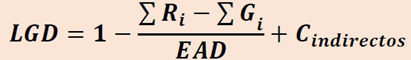

#### <p style="color:blue;">4.1. RECUPERACIONES Y GASTOS</p>

##### <p style="color:green">RECUPERACIONES

In [17]:
df_const_LGD[["recoveries"]]

,recoveries
1,117.08
8,189.06
9,269.29
12,444.30
14,645.10
...,...
443747,0.00
443755,0.00
443763,0.00
443771,0.00


Para las **recuperaciones** disponemos de la variable `recoveries`, la cuál viene definida como **"Recuperación bruta posterior a la cancelación de la deuda"**. \
Se trata de recuperaciones asociadas a la cartera de préstamos que estamos modelizando y no a recuperaciones de préstamos anteriores.

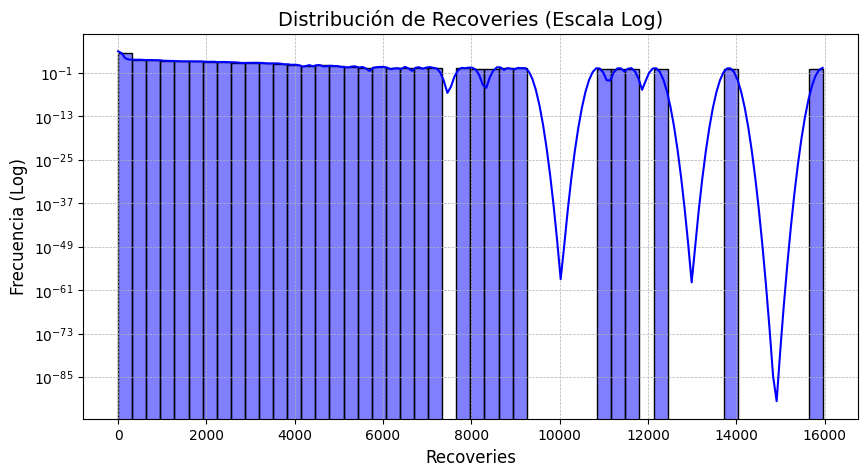

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df_const_LGD["recoveries"], bins=50, kde=True, color="blue", edgecolor="black")
plt.yscale("log")  # Aplicamos escala logarítmica para visualizar mejor los datos

plt.title("Distribución de Recoveries (Escala Log)", fontsize=14)
plt.xlabel("Recoveries", fontsize=12)
plt.ylabel("Frecuencia (Log)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

In [19]:
df_explot_LGD[["recoveries"]]

,recoveries
136692,0.0
141787,0.0
142644,0.0
146011,0.0
164645,0.0
...,...
402762,0.0
402788,0.0
402794,0.0
402835,0.0


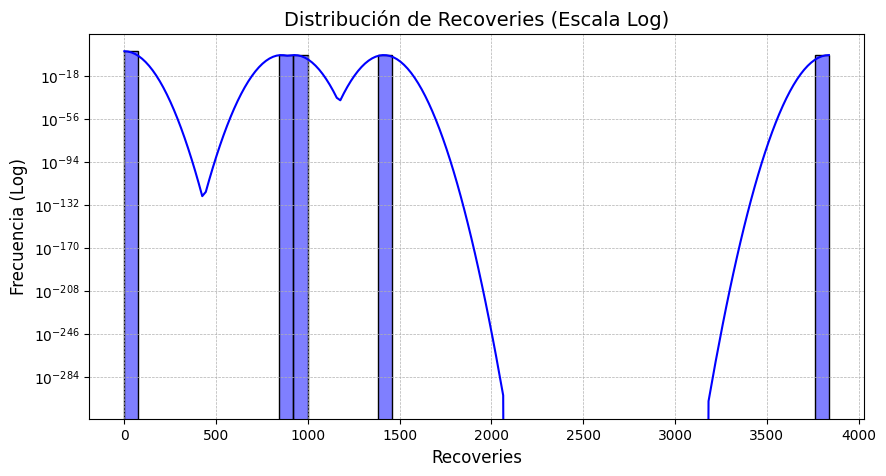

In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(df_explot_LGD["recoveries"], bins=50, kde=True, color="blue", edgecolor="black")
plt.yscale("log")  # Aplicamos escala logarítmica para visualizar mejor los datos

plt.title("Distribución de Recoveries (Escala Log)", fontsize=14)
plt.xlabel("Recoveries", fontsize=12)
plt.ylabel("Frecuencia (Log)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

##### <p style="color:green">GASTOS

Tenemos 2 tipos de gastos:
- `collection_recovery_fee`: Comisión de cobro posterior a la cancelación de la deuda.
- `total_rec_late_fee`: Recargos por mora recibidos hasta la fecha.

In [21]:
#sólo considerando préstamos con 'collection_recovery_fee' > 0
df_const_LGD[df_const_LGD['collection_recovery_fee']>0]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,earliest_cr_line_date,months_earliest_cr_line_date,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status
1,2500,2500,2500.0,15.27,59.83,30000.0,n,car,1.00,0.0,...,1999-04-01,152,2013-04-01,16,2013-09-01,21,other,0,1,Charged Off
8,5600,5600,5600.0,21.28,152.39,40000.0,n,small_business,5.55,0.0,...,2004-04-01,92,2012-04-01,4,2012-08-01,8,teacher,0,1,Charged Off
9,5375,5375,5350.0,12.69,121.45,15000.0,n,other,18.08,0.0,...,2004-09-01,87,2012-11-01,11,2013-03-01,15,other,0,2,Charged Off
12,9000,9000,9000.0,13.49,305.38,30000.0,n,debt_consolidation,10.08,0.0,...,2004-04-01,92,2012-07-01,7,2012-11-01,11,other,0,1,Charged Off
14,10000,10000,10000.0,10.65,325.74,100000.0,n,other,7.06,0.0,...,1991-05-01,247,2013-10-01,22,2014-03-01,27,other,0,1,Charged Off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442749,8975,8975,8975.0,22.90,346.96,55000.0,n,house,17.94,0.0,...,2003-12-01,121,2015-02-01,13,2015-07-01,18,other,0,-1,Charged Off
443064,12875,12875,12875.0,16.99,319.91,31000.0,n,debt_consolidation,27.02,0.0,...,1988-03-01,310,2014-12-01,11,2015-05-01,16,teacher,0,1,Charged Off
443426,18225,18225,18225.0,24.99,724.53,52000.0,n,debt_consolidation,25.36,0.0,...,1999-06-01,175,2015-02-01,13,2015-06-01,17,manager,0,2,Charged Off
443551,18000,18000,18000.0,14.98,623.80,80000.0,n,debt_consolidation,20.79,0.0,...,2001-07-01,150,2014-11-01,10,2016-01-01,24,teacher,0,1,Charged Off


In [22]:
df_explot_LGD[df_explot_LGD['collection_recovery_fee']>0]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,next_pymnt_date,months_next_pymnt_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status
370706,5500,5500,5500.0,15.59,192.26,46000.0,n,debt_consolidation,16.64,2.0,...,2015-06-01,5,2015-09-01,8,2016-02-01,13.0,management,0,3,Charged Off
383521,22950,22950,22950.0,14.31,787.84,50000.0,n,credit_card,5.54,1.0,...,2015-04-01,3,2015-09-01,8,2016-02-01,13.0,management,0,0,Charged Off
386414,5025,5025,5025.0,16.49,177.89,60000.0,n,medical,9.72,0.0,...,2015-05-01,4,2015-08-01,7,2016-02-01,13.0,management,0,3,Charged Off
402543,8000,8000,8000.0,9.49,256.23,35000.0,n,debt_consolidation,11.38,0.0,...,2016-01-01,12,2015-06-01,5,2016-02-01,13.0,management,0,0,Charged Off


In [23]:
#sólo considerando préstamos con 'total_rec_late_fee' > 0
df_const_LGD[df_const_LGD['total_rec_late_fee']>0]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,earliest_cr_line_date,months_earliest_cr_line_date,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status
50,15000,15000,15000.0,9.91,483.38,80000.00,n,debt_consolidation,9.12,0.0,...,1992-04-01,236,2014-10-01,34,2015-03-01,39,inc,0,2,Charged Off
64,10000,10000,9975.0,10.65,215.69,45996.00,n,debt_consolidation,21.73,0.0,...,1997-05-01,175,2015-04-01,40,2015-06-01,42,inc,0,1,Charged Off
151,7200,7200,7200.0,12.42,240.59,48000.00,n,major_purchase,17.43,0.0,...,2006-09-01,63,2015-02-01,38,2015-12-01,48,other,0,2,Charged Off
251,12000,12000,12000.0,7.51,373.33,42000.00,n,debt_consolidation,10.74,0.0,...,1994-06-01,210,2015-01-01,37,2015-01-01,37,inc,0,1,Charged Off
560,28000,18625,18600.0,12.42,418.27,84996.00,n,debt_consolidation,23.41,0.0,...,1998-12-01,156,2013-03-01,15,2016-01-01,49,other,0,1,Charged Off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439574,7200,7200,7200.0,20.50,269.42,60000.00,n,other,26.94,1.0,...,1996-03-01,214,2015-12-01,23,2016-01-01,24,nurse,0,1,Charged Off
441050,20125,20125,20125.0,16.99,500.05,45000.00,n,credit_card,28.11,0.0,...,2000-05-01,164,2015-10-01,21,2015-01-01,12,nurse,0,1,Charged Off
441156,6000,6000,6000.0,9.67,192.68,28863.49,n,credit_card,10.69,2.0,...,1998-07-01,186,2016-01-01,24,2016-01-01,24,service,0,-1,Default
442710,30000,30000,29850.0,13.53,1018.50,72300.00,n,debt_consolidation,24.18,0.0,...,2000-09-01,160,2016-01-01,24,2016-01-01,24,sale,0,1,Charged Off


In [24]:
df_explot_LGD[df_explot_LGD['total_rec_late_fee']>0]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,next_pymnt_date,months_next_pymnt_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status
193808,12000,12000,12000.0,13.33,275.07,54588.00,n,credit_card,19.74,0.0,...,2016-01-01,5,2016-01-01,5,2016-02-01,6.0,technology,0,0,Charged Off
239330,5000,5000,5000.0,16.55,177.15,35000.00,n,debt_consolidation,25.17,0.0,...,2015-10-01,4,2016-01-01,7,2016-02-01,8.0,finance,0,0,Charged Off
319928,21000,21000,21000.0,11.53,692.80,76000.00,n,other,6.57,6.0,...,2015-12-01,8,2016-01-01,9,2016-02-01,10.0,customer_service,0,0,Charged Off
322655,30000,30000,30000.0,12.69,677.85,85000.00,n,credit_card,21.46,0.0,...,2016-01-01,9,2016-01-01,9,2016-02-01,10.0,management,0,0,Charged Off
344601,15000,15000,15000.0,8.18,471.30,44159.08,n,home_improvement,6.83,0.0,...,2016-01-01,10,2016-01-01,10,2016-02-01,11.0,education,0,0,Charged Off
350596,15000,15000,15000.0,13.99,348.95,74116.00,n,credit_card,19.87,0.0,...,2015-08-01,6,2016-01-01,11,2016-02-01,12.0,engineering,0,0,Charged Off
359442,10000,10000,10000.0,12.69,335.45,24000.00,n,credit_card,20.80,0.0,...,2016-01-01,11,2016-01-01,11,2016-02-01,12.0,other,0,3,Charged Off
363498,20000,20000,19975.0,13.99,683.46,53000.00,n,debt_consolidation,36.62,2.0,...,2015-12-01,10,2016-01-01,11,2016-02-01,12.0,education,0,0,Charged Off
365146,20000,20000,20000.0,15.59,699.10,50000.00,n,home_improvement,21.36,1.0,...,2016-01-01,11,2016-01-01,11,2016-02-01,12.0,customer_service,0,0,Charged Off
367075,18050,18050,18050.0,19.24,470.62,58600.00,n,debt_consolidation,13.82,1.0,...,2015-12-01,10,2016-01-01,11,2016-02-01,12.0,education,0,0,Charged Off


##### <p style="color:green">GASTOS INDIRECTOS

No disponemos información para estimar los **gastos indirectos**, por lo que vamos a tener que presuponer que son 0.

#### <p style="color:blue;">4.2. EAD</p>

La EAD es la exposición de en el momento del default. Habría que diferenciar entre:
- Productos no línea (Ej: hipotecas, préstamos): No hay que estimar nada, sólo sumar el **capital pendiente** más los **intereses devengados no pagados**.
- Productos línea (Ej: tarjetas de crédito): En este caso la EAD se calcularía como el **saldo dispuesto** más el **saldo disponible** multiplicado con un **factor de conversión (CCF)**

No disponemos de ninguna variable que informe de cuál era la exposición en el momento de default. Ni siquiera disponemos de la fecha de entrada en default del acreditado. Por ello no podemos calcular cuál era exactamente la exposición en dicho momento, por lo tanto debemos limitarnos a aproximar que la exposición en el momento del default será igual a:\
**`EAD = Exposición en el momento fin de periodo de observación`**

Además, los importes tanto de las recuperaciones como de los costes, son facilitados a fecha fin de periodo de observación, por lo que debemos llevar la EAD a dicha fecha para poder comparar todas las cantidades.

Realmente tampoco disponemos directamente de una variable que informe de cuál era la exposición a fin de ventana de observación, sólo disponemos de la variable `out_prncp`que nos informa del principal pendiente, pero no incluye los intereses. **Vamos a utilizar dicha variable como aproximación de la EAD**. 

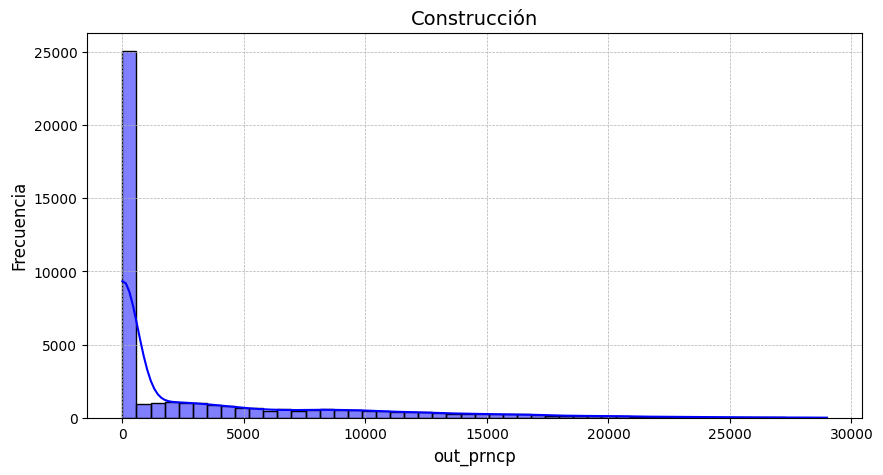

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(df_const_LGD["out_prncp"], bins=50, kde=True, color="blue", edgecolor="black")

plt.title("Construcción", fontsize=14)
plt.xlabel("out_prncp", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

Observamos que en el conjunto de construcción, la mayoria procesos recuperatorios, el principal que queda por pagar es 0. Lo cuál tiene sentido debido a que estamos seleccionando un periodo de 8 años, en el cuál muchos de los procesos recuperatorios han sido saldados.

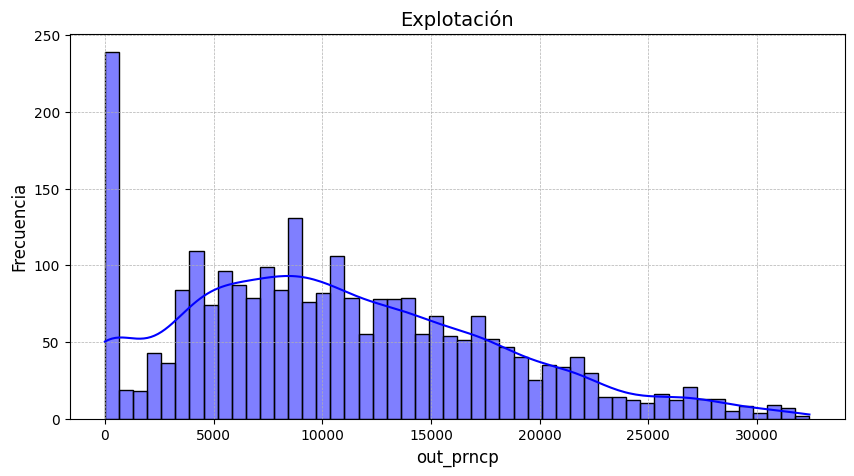

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(df_explot_LGD["out_prncp"], bins=50, kde=True, color="blue", edgecolor="black")

plt.title("Explotación", fontsize=14)
plt.xlabel("out_prncp", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

Para el conjunto de explotación, aunque también es prodominante que el principal sea 0, pero representa un % menor, lo cuál tiene sentido puesto que la muestra temporal es sólo de 1 año.

In [27]:
df_const_LGD[df_const_LGD["out_prncp"]!=0]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,earliest_cr_line_date,months_earliest_cr_line_date,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status
183,22475,22475,22425.0,15.27,537.87,52000.0,n,debt_consolidation,15.23,0.0,...,1989-09-01,267,2015-12-01,48,2016-01-01,49,other,0,0,Charged Off
188,8400,8400,8150.0,16.77,207.73,87996.0,n,major_purchase,11.35,0.0,...,2003-09-01,99,2015-12-01,48,2016-01-01,49,other,0,1,Charged Off
212,21000,11800,11500.0,17.27,294.98,109000.0,n,debt_consolidation,7.75,0.0,...,1973-12-01,456,2015-12-01,48,2016-01-01,49,technology,0,1,Charged Off
381,4125,4125,4125.0,12.69,93.21,36000.0,n,car,17.73,0.0,...,2002-09-01,111,2015-12-01,48,2016-01-01,49,other,0,1,Charged Off
581,18500,11925,11900.0,19.03,309.54,68000.0,n,debt_consolidation,20.89,0.0,...,1985-07-01,317,2016-01-01,49,2016-01-01,49,inc,0,2,Charged Off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443693,15000,15000,14975.0,7.90,469.36,80000.0,n,credit_card,24.17,0.0,...,2001-05-01,152,2016-01-01,24,2016-01-01,24,other,0,-1,Charged Off
443701,25000,25000,24950.0,7.62,779.04,225000.0,n,credit_card,10.45,0.0,...,1995-06-01,223,2016-01-01,24,2016-01-01,24,management,0,1,Charged Off
443702,18000,18000,17925.0,7.90,563.23,110000.0,n,debt_consolidation,22.01,0.0,...,2004-04-01,117,2016-01-01,24,2016-01-01,24,other,0,2,Charged Off
443747,10000,10000,10000.0,10.99,327.34,150000.0,n,credit_card,10.32,4.0,...,1994-11-01,230,2016-01-01,24,2016-01-01,24,other,0,1,Charged Off


#### <p style="color:blue;">4.3. CÁLCULO LGD DE PROCESOS CERRADOS Y ABIERTOS</p>

Tal y cómo lo hemos definido al inicio, los **procesos recuperatorios** pueder ser:
- **Cerrados**: Son operaciones que están en **charged-off**.
- **Abiertos**: Son operaciones que aún están en **default**.

Con esta segmentación, podemos calcular la LGD de los procesos cerrados (dónde ya se conoce la recuperación final) y luego extrapolarla a los abiertos usando distintos métodos:

1. **Curvas de recuperación basadas en segmentos (forma más habitual)**: Este método se basa en la evolución histórica de las recuperaciones observadas en procesos cerrados y su extrapolación a los abiertos. Pasos:
    - Segmentar los procesos recuperatorios CERRADOS, en base a las variables más importantes que afectan a las recuperaciones:
        - LtV de la garantía (para productos con garantía) --> no aplica a nuestro dataset
        - Tiempo en Default hasta fecha fin de ventana observación
        - Porcentaje de recuperación observada hasta fecha fin de ventana de observación
        - ...
    - Para cada segmento de los procesos CERRADOS, calcular la tasa acumulada de recuperación a lo largo del tiempo. Deberíamos observar que la recuperación tiende a ser rápida en los primeros meses/años tras el default y luego se estabiliza.\
      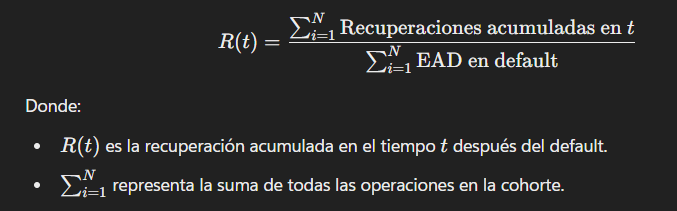

    - Ahora debemos extrapolar dichas tasas a los procesos recuperatorios ABIERTOS:
        1. Identificar en qué punto del tiempo respecto al default y que % de recuperación tiene.
        2. Asignar a cada proceso abierto la curva de recuperación de su segmento correspondiente
        3. Proyectar las recuperaciones futuras extrapolando la tendencia observada en los segmentos de los CERRADOS.


2. **Modelos de Machine Learning**
    - Variables a considerar en el modelo:
        - Variable dependiente (target): LGD, variable dicotómica que toma:
            - el valor 0 si la entidad recupera toda la deuda
            - el valor 1 si la entidad no recupera nada
        - Variables independientes (fetaures): todas las variables que disponemos
    - Modelos: Regresión lineal, Random Forest, XGBoost y redes neuronales
    - Entrenamiento, test y validación:
        - Entrenamiento --> dataset de construcción
        - Validación --> dataset de construcción.
        - Predicción (sin validación) --> dataset de explotación\
    
### **Comparar la LGD media resultante con la de la CRR para IRB básico que es un 45%**

#### <p style="color:green">PROCESOS RECUPERATORIOS CERRADOS

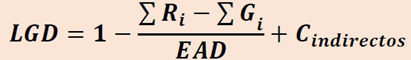

Función para calcular la LGD

In [28]:
def calculate_lgd(row):
    if row['out_prncp'] == 0:
        return 0  # Si el principal pendiente es 0, no hay pérdida
    else:
        return (1- ((row['recoveries']-row['collection_recovery_fee']-row['total_rec_late_fee'])/row['out_prncp']))

**CONSTRUCCIÓN**

In [29]:
df_const_cerrados = df_const_LGD[(df_const_LGD.loan_status.isin(["Charged Off", "Does not meet the credit policy. Status:Charged Off"]))]

In [30]:
df_const_cerrados.shape

(41375, 49)

In [31]:
df_const_cerrados['LGD'] = df_const_cerrados.apply(calculate_lgd, axis=1)

/tmp/ipykernel_2759/3503674583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_const_cerrados['LGD'] = df_const_cerrados.apply(calculate_lgd, axis=1)


La LGD media para los procesos recuperatorios cerrados de la muestra de construcción es de **41,5%**, cifra que se encuentra algo por debajo de la LGD correspondiente para el método **IRB básico** para préstamos minoristas sin garantía, que se sitúa en el **45%**, con lo cuál tiene sentido.

In [32]:
df_const_cerrados['LGD'].mean()

0.41566159524160945

Observamos en el hsitograma como la mayor parte de los préstamos se distribuyen entre los valores 0 y 1, es decir:
- No se recupera nada del impago y la LGD es 1.
- Se recupera todo lo impagado y la LGD es 0.

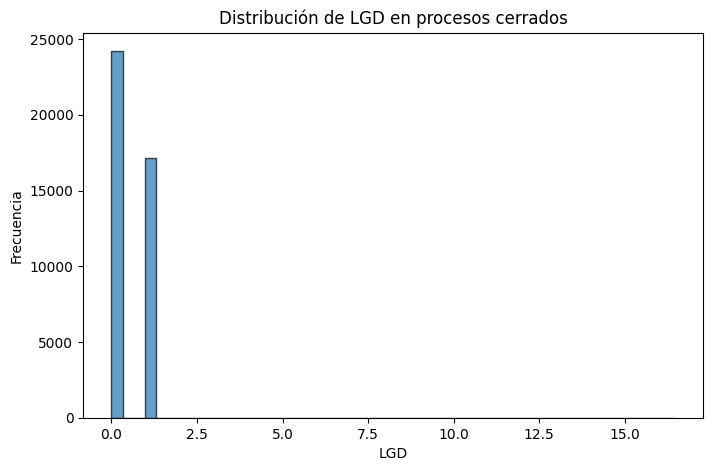

In [33]:

plt.figure(figsize=(8, 5))
plt.hist(df_const_cerrados['LGD'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('LGD')
plt.ylabel('Frecuencia')
plt.title('Distribución de LGD en procesos cerrados')
plt.show()


Tal y como podemos observar, del total de 41.375 préstamos cerrados, sólo 288 tienen un valor distinto de LGD a 0 o 1, por lo que podemos convertir el problema de regresión en un problema de clasificación binaria, recupera (1), no recupera (0).

In [34]:
df_const_cerrados.shape

(41375, 50)

In [35]:
df_const_cerrados[(df_const_cerrados['LGD'] != 0) & (df_const_cerrados['LGD'] != 1)]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,months_earliest_cr_line_date,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status,LGD
1596,20000,20000,19975.0,14.27,468.17,80500.0,n,debt_consolidation,9.17,1.0,...,195,2015-12-01,48,2016-01-01,49,other,0,1,Charged Off,1.008207
3668,12000,12000,11500.0,12.42,269.49,123000.0,n,debt_consolidation,16.81,0.0,...,335,2016-01-01,50,2016-01-01,50,other,0,1,Charged Off,1.010664
4210,6625,6625,6625.0,14.27,155.09,25995.0,n,debt_consolidation,24.68,0.0,...,99,2016-01-01,50,2016-01-01,50,finance,0,1,Charged Off,1.010210
8188,22750,16950,16925.0,17.99,430.33,45000.0,n,debt_consolidation,15.65,1.0,...,225,2015-12-01,51,2016-01-01,52,other,0,1,Charged Off,1.005925
10517,7000,7000,7000.0,11.99,155.68,75000.0,n,other,11.78,0.0,...,161,2016-01-01,54,2016-01-01,54,other,0,1,Charged Off,1.014052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437955,3250,3250,3250.0,16.24,114.65,43000.0,n,debt_consolidation,6.75,2.0,...,143,2015-09-01,20,2016-01-01,24,manager,0,1,Charged Off,1.009143
438839,12000,12000,11950.0,16.99,427.78,120000.0,n,debt_consolidation,19.65,1.0,...,228,2016-01-01,24,2016-01-01,24,manager,0,1,Charged Off,1.012683
439463,10000,10000,10000.0,13.98,341.68,75000.0,n,credit_card,21.74,0.0,...,86,2016-01-01,24,2016-01-01,24,other,0,-1,Charged Off,1.004487
439574,7200,7200,7200.0,20.50,269.42,60000.0,n,other,26.94,1.0,...,214,2015-12-01,23,2016-01-01,24,nurse,0,1,Charged Off,1.004265


De esos 288 préstamos, todos tienen una LGD > 1, no existe ningún préstamo que tenga una LGD entre 0 y 1.

In [36]:
df_const_cerrados[(df_const_cerrados['LGD'] > 0) & (df_const_cerrados['LGD'] < 1)]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,months_earliest_cr_line_date,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status,LGD


<Axes: >

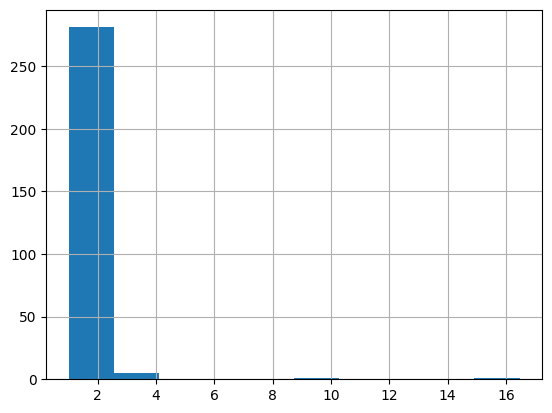

In [37]:
df_const_cerrados[(df_const_cerrados['LGD'] > 1)]['LGD'].hist()

Dado que no se puede obtener una LGD > 1, vamos a considerar que los 288 casos que ocurre esto se trata de outliers, y los vamos a sustituir por LGD=1

In [38]:
df_const_cerrados['LGD'] = [1 if lgd > 1 else lgd for lgd in df_const_cerrados['LGD']]

/tmp/ipykernel_2759/3136511165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_const_cerrados['LGD'] = [1 if lgd > 1 else lgd for lgd in df_const_cerrados['LGD']]


Finalmente hemos transformado el problema de estimación de la LGD a un problema de clasificiación binario:
- LGD = 0 --> recupera
- LGD = 1 --> no recupera

In [39]:
df_const_cerrados['LGD'].value_counts()

LGD
0.0    24215
1.0    17160
Name: count, dtype: int64

La nueva estimación de la LGD para la muestra de construcción de los procesos recuperatorios cerrados, al normalizar los valores outliers, cae ligeramente respecto a la original y se sitúa en el 41,47%.

In [40]:
df_const_cerrados['LGD'].mean()

0.4147432024169184

Guardamos el dataframe sin normalizar porque lo necesitaremos así para modelar segmentando (último notebook)

In [41]:
df_const_cerrados.to_csv("df_const_cerrados_LGD_sin_normalizar.csv", index=False)

**EXPLOTACIÓN**

In [42]:
df_explot_cerrados = df_explot_LGD[(df_explot_LGD.loan_status.isin(["Charged Off", "Does not meet the credit policy. Status:Charged Off"]))]

In [43]:
df_explot_cerrados.shape

(2228, 52)

In [44]:
df_explot_cerrados['LGD'] = df_explot_cerrados.apply(calculate_lgd, axis=1)

/tmp/ipykernel_2759/3147813913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explot_cerrados['LGD'] = df_explot_cerrados.apply(calculate_lgd, axis=1)


Se observa como para la muestra de explotación la LGD de los procesos recuperatorios ha pasado de un 42% para la muestra de construcción a un 91% para la muestra de explotación. Tratándose de la misma cartera de préstamos, este incremento tan pronunciado no tendría sentido si no tuviésemos en cuenta que para la muestra de construcción estamos considerando un histórico lo suficientemente amplio (desde enero de 2007 a diciembre 2014, es decir 8 años) como para considerar cerrados los procesos que la entidad ha clasificado como "Charged Off", mientras que para la muestra de explotación sólo estamos teniendo en cuenta 1 año (2015), tiempo insuficiente para considerar cómo realmente cerrado un procesos clasificado como "Charged Off" (ya que pese a estar clasificado como cerrado por incobrable, se pueden seguir obteniendo flujos recuperatorios).

In [45]:
df_explot_cerrados['LGD'].mean()

0.907109352323785

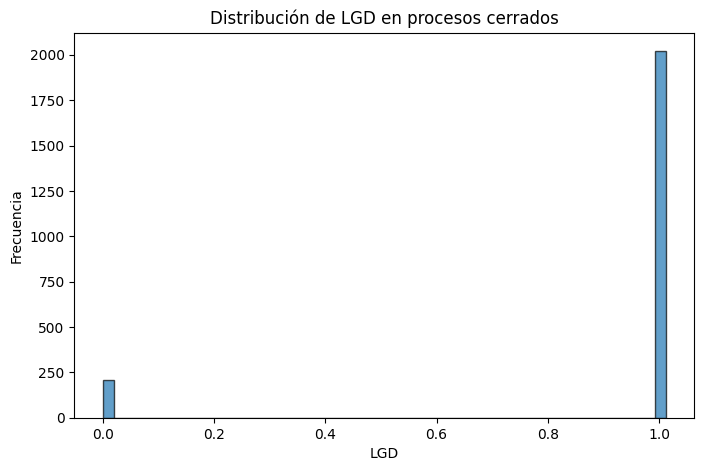

In [46]:
plt.figure(figsize=(8, 5))
plt.hist(df_explot_cerrados['LGD'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('LGD')
plt.ylabel('Frecuencia')
plt.title('Distribución de LGD en procesos cerrados')
plt.show()


In [47]:
df_explot_cerrados[(df_explot_cerrados['LGD']!= 0) & (df_explot_cerrados['LGD']!= 1)]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,next_pymnt_date,months_next_pymnt_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status,LGD
193808,12000,12000,12000.0,13.33,275.07,54588.00,n,credit_card,19.74,0.0,...,5,2016-01-01,5,2016-02-01,6.0,technology,0,0,Charged Off,1.001330
239330,5000,5000,5000.0,16.55,177.15,35000.00,n,debt_consolidation,25.17,0.0,...,4,2016-01-01,7,2016-02-01,8.0,finance,0,0,Charged Off,1.003290
319928,21000,21000,21000.0,11.53,692.80,76000.00,n,other,6.57,6.0,...,8,2016-01-01,9,2016-02-01,10.0,customer_service,0,0,Charged Off,1.002045
322655,30000,30000,30000.0,12.69,677.85,85000.00,n,credit_card,21.46,0.0,...,9,2016-01-01,9,2016-02-01,10.0,management,0,0,Charged Off,1.001273
344601,15000,15000,15000.0,8.18,471.30,44159.08,n,home_improvement,6.83,0.0,...,10,2016-01-01,10,2016-02-01,11.0,education,0,0,Charged Off,1.002105
350596,15000,15000,15000.0,13.99,348.95,74116.00,n,credit_card,19.87,0.0,...,6,2016-01-01,11,2016-02-01,12.0,engineering,0,0,Charged Off,1.001253
359442,10000,10000,10000.0,12.69,335.45,24000.00,n,credit_card,20.80,0.0,...,11,2016-01-01,11,2016-02-01,12.0,other,0,3,Charged Off,1.002115
363498,20000,20000,19975.0,13.99,683.46,53000.00,n,debt_consolidation,36.62,2.0,...,10,2016-01-01,11,2016-02-01,12.0,education,0,0,Charged Off,1.002239
365146,20000,20000,20000.0,15.59,699.10,50000.00,n,home_improvement,21.36,1.0,...,11,2016-01-01,11,2016-02-01,12.0,customer_service,0,0,Charged Off,1.002355
367075,18050,18050,18050.0,19.24,470.62,58600.00,n,debt_consolidation,13.82,1.0,...,10,2016-01-01,11,2016-02-01,12.0,education,0,0,Charged Off,1.001461


Todos las LGDs distintas de 0 y 1 tienen valores >1, aunque se trata de valores muy próximos a 1.

In [48]:
df_explot_cerrados[df_explot_cerrados['LGD'] > 1]['LGD']

193808    1.001330
239330    1.003290
319928    1.002045
322655    1.001273
344601    1.002105
350596    1.001253
359442    1.002115
363498    1.002239
365146    1.002355
367075    1.001461
376118    1.003018
381719    1.012476
386198    1.002354
387816    1.002323
Name: LGD, dtype: float64

**Ya que la LGD desminuye a medida que se incrementa el tiempo en default, estimar los procesos recuperatorios abiertos del conjunto de explotación, a partir de los cerrados de este mismo conjunto, sería sobre-estimar la LGD de explotación, por ello es preferible llevar a cabo el siguiente proceso:**
1. Calcular la LGD de los procesos recuperatorios cerrados del conjunto de construcción (calculado anteriormente)
2. Llevar a cabo una segmentación de dichos procesos recuperatorios cerrados.
3. Estimar los procesos recuperatorios abiertos del conjunto de explotación a partir de los cerrados (mediante las medias de cada segmento o mediante algoritmos de ML/AI)
4. Estimar los procesos recuperatorios de los abiertos y cerrados del conjunto de explotación a partir del conjunto total (cerrados + abiertos) del conjunto de construcción (mediante las medias de cada segmento o mediante algoritmos de ML/AI).

In [49]:
df_explot_cerrados

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,next_pymnt_date,months_next_pymnt_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status,LGD
136692,9000,9000,9000.0,6.24,274.78,52000.0,n,credit_card,16.87,0.0,...,3,2016-01-01,3,2016-02-01,4.0,other,0,0,Charged Off,1.0
141787,30000,30000,30000.0,12.69,677.85,82000.0,n,debt_consolidation,23.59,0.0,...,4,2016-01-01,4,2016-02-01,5.0,healthcare,0,0,Charged Off,1.0
142644,8000,8000,8000.0,9.99,258.10,44000.0,n,debt_consolidation,29.60,0.0,...,4,2016-01-01,4,2016-02-01,5.0,other,0,0,Charged Off,1.0
146011,9600,9600,9600.0,5.32,289.11,72000.0,n,credit_card,10.25,0.0,...,4,2016-01-01,4,2016-02-01,5.0,management,0,0,Charged Off,1.0
164645,24000,24000,24000.0,8.18,754.07,115000.0,n,debt_consolidation,15.62,0.0,...,5,2016-01-01,5,2016-02-01,6.0,management,0,0,Charged Off,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402762,16000,16000,16000.0,12.99,363.97,48000.0,n,credit_card,20.03,0.0,...,12,2016-01-01,12,2016-02-01,13.0,legal,0,0,Charged Off,1.0
402788,4700,4700,4700.0,15.99,165.22,65083.0,n,debt_consolidation,20.06,0.0,...,12,2016-01-01,12,2016-02-01,13.0,engineering,0,0,Charged Off,1.0
402794,11875,11875,11875.0,17.14,296.02,35000.0,n,debt_consolidation,23.85,0.0,...,12,2016-01-01,12,2016-02-01,13.0,education,0,0,Charged Off,1.0
402835,33000,33000,33000.0,14.31,773.17,94000.0,n,debt_consolidation,22.98,0.0,...,12,2016-01-01,12,2016-02-01,13.0,operator,0,0,Charged Off,1.0


Guardamos el dataframe sin normalizar porque lo necesitaremos así para modelar segmentando (último notebook)

In [50]:
df_explot_cerrados.to_csv("df_explot_cerrados_LGD_sin_normalizar.csv", index=False)

#### <p style="color:green">PROCESOS RECUPERATORIOS ABIERTOS

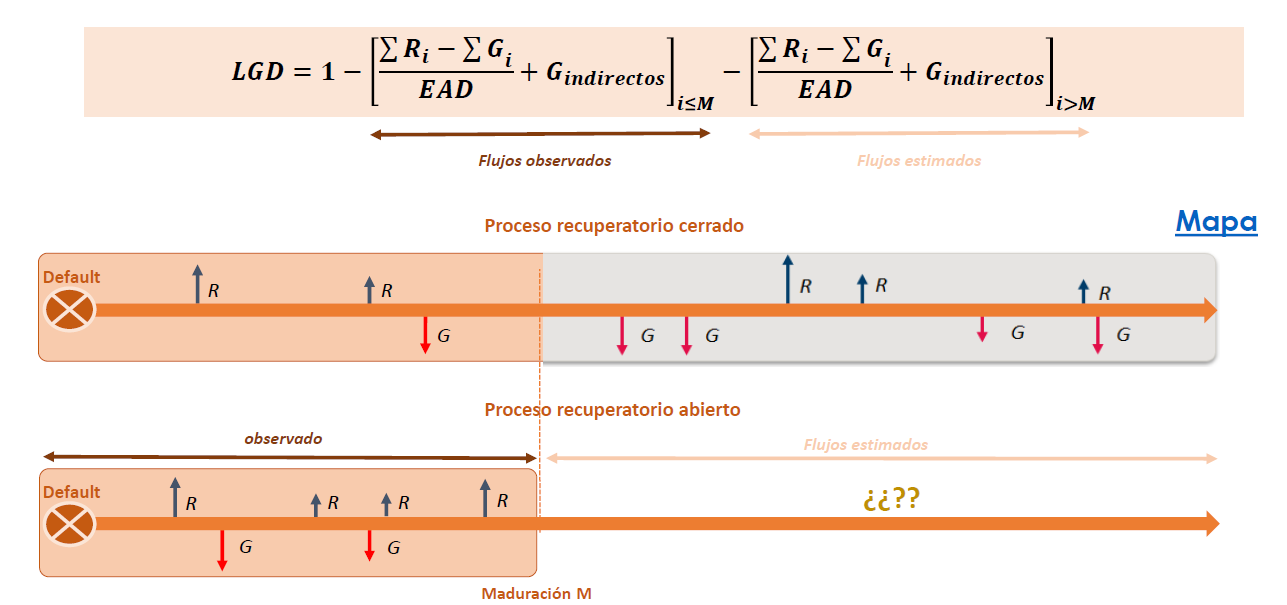

**CONSTRUCCIÓN**

In [51]:
df_const_abiertos = df_const_LGD[(df_const_LGD.loan_status.isin(["Default"]))]

In [52]:
df_const_abiertos

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,earliest_cr_line_date,months_earliest_cr_line_date,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status
318,5000,5000,5000.0,12.42,167.08,30000.0,n,debt_consolidation,23.84,0.0,...,2001-06-01,126,2012-06-01,6,2016-01-01,49,other,0,2,Default
7620,6000,6000,6000.0,15.99,210.92,20000.0,n,debt_consolidation,13.80,0.0,...,2007-10-01,47,2014-09-01,36,2016-01-01,52,other,0,1,Default
11759,18000,18000,17975.0,15.23,430.40,94000.0,n,major_purchase,1.89,0.0,...,2001-12-01,115,2013-06-01,23,2013-06-01,23,operations,0,-1,Default
13439,17400,17400,17375.0,5.99,529.27,56000.0,n,home_improvement,19.31,0.0,...,1995-12-01,186,2014-06-01,36,2016-01-01,55,other,0,1,Default
13856,18000,18000,17750.0,7.49,559.83,63000.0,n,credit_card,7.92,0.0,...,1999-09-01,140,2011-07-01,2,2011-06-01,1,other,0,-1,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443099,9925,9925,9900.0,14.47,341.49,25000.0,n,debt_consolidation,6.13,3.0,...,2003-06-01,127,2016-01-01,24,2016-01-01,24,other,0,1,Default
443201,12000,12000,12000.0,18.25,306.36,65000.0,n,credit_card,17.76,0.0,...,1988-10-01,303,2016-01-01,24,2016-01-01,24,teacher,0,1,Default
443271,20000,20000,20000.0,7.90,625.81,100000.0,n,debt_consolidation,19.58,1.0,...,2004-01-01,120,2016-01-01,24,2016-01-01,24,other,0,2,Default
443339,12000,12000,11950.0,13.98,410.02,60000.0,n,debt_consolidation,23.18,1.0,...,1993-12-01,241,2016-01-01,24,2016-01-01,24,sale,0,-1,Default


Guardamos el dataframe sin normalizar porque lo necesitaremos así para modelar segmentando (último notebook)

In [53]:
df_const_abiertos.to_csv("df_const_abiertos_LGD_sin_normalizar.csv", index=False)

**EXPLOTACIÓN**

In [54]:
df_explot_abiertos = df_explot_LGD[(df_explot_LGD.loan_status.isin(["Default"]))]

In [55]:
df_explot_abiertos

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,...,last_pymnt_date,months_last_pymnt_date,last_credit_pull_date,months_last_credit_pull_date,next_pymnt_date,months_next_pymnt_date,filtered_emp_title,zip_code_grouped,addr_state_grouped,loan_status
165139,19000,19000,19000.0,14.65,448.53,89000.0,n,debt_consolidation,21.14,0.0,...,2015-10-01,2,2016-01-01,5,2016-02-01,6.0,healthcare,0,0,Default
169151,10000,10000,9950.0,13.33,338.54,50000.0,n,debt_consolidation,38.17,0.0,...,2016-01-01,5,2016-01-01,5,2016-02-01,6.0,management,0,0,Default
173000,12000,12000,12000.0,8.18,377.04,132000.0,n,debt_consolidation,9.29,0.0,...,2016-01-01,5,2016-01-01,5,2016-01-01,5.0,management,0,0,Default
173300,20000,20000,20000.0,13.99,683.46,55000.0,n,debt_consolidation,25.97,1.0,...,2015-12-01,4,2016-01-01,5,2016-02-01,6.0,operator,0,0,Default
175486,14025,14025,14025.0,12.29,467.78,35000.0,n,debt_consolidation,18.96,0.0,...,2016-01-01,5,2016-01-01,5,2016-02-01,6.0,other,0,0,Default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400844,3350,3350,3350.0,11.99,111.26,24000.0,n,debt_consolidation,25.80,0.0,...,2016-01-01,12,2016-01-01,12,2016-02-01,13.0,support,0,0,Default
401110,15000,15000,15000.0,8.67,308.98,42000.0,n,credit_card,16.49,1.0,...,2015-04-01,3,2016-01-01,12,2016-02-01,13.0,other,0,0,Default
401458,14500,14500,14500.0,13.66,493.19,60000.0,n,car,18.82,0.0,...,2015-01-01,0,2016-01-01,12,2016-02-01,13.0,customer_service,0,0,Default
401925,15000,15000,15000.0,6.49,459.67,100000.0,n,debt_consolidation,12.38,0.0,...,2016-01-01,12,2016-01-01,12,2016-02-01,13.0,management,0,0,Default


Guardamos el dataframe sin normalizar porque lo necesitaremos así para modelar segmentando (último notebook)

In [56]:
df_explot_abiertos.to_csv("df_explot_abiertos_LGD_sin_normalizar.csv", index=False)

### <p style="color:red;">5.ÚLTIMO PASO</p>

#### <p style="color:blue;">5.1. VARIABLE LOAN STATUS</p>

La variable `loan_status`tanto para construcción como para explotación, no nos va a servir puesto que para los cerrados siempre será "Chraged Off" y para los abiertos será "Default", por lo que se tratará de un valor único en ambos datasets, y aquellas variables con valores únicos no sirven para modelizar, por lo que procedemos a eliminarlos. 

In [57]:
df_const_cerrados['loan_status'].unique()

array(['Charged Off',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [58]:
df_const_abiertos['loan_status'].unique()

array(['Default'], dtype=object)

In [59]:
df_explot_cerrados['loan_status'].unique()

array(['Charged Off'], dtype=object)

In [60]:
df_explot_abiertos['loan_status'].unique()

array(['Default'], dtype=object)

In [61]:
df_const_cerrados.drop('loan_status', axis=1, inplace=True)

/tmp/ipykernel_2759/2478531800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_const_cerrados.drop('loan_status', axis=1, inplace=True)


In [62]:
df_const_abiertos.drop('loan_status', axis=1, inplace=True)

/tmp/ipykernel_2759/830204616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_const_abiertos.drop('loan_status', axis=1, inplace=True)


In [63]:
df_explot_cerrados.drop('loan_status', axis=1, inplace=True)

/tmp/ipykernel_2759/26725375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explot_cerrados.drop('loan_status', axis=1, inplace=True)


In [64]:
df_explot_abiertos.drop('loan_status', axis=1, inplace=True)

/tmp/ipykernel_2759/2471309860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explot_abiertos.drop('loan_status', axis=1, inplace=True)


#### <p style="color:blue;">5.2. ELIMINAR VARIABLES FECHA</p>

In [65]:
df_const_cerrados.drop(['earliest_cr_line_date', 'issue_date','last_pymnt_date','last_credit_pull_date'], axis=1, inplace=True)

/tmp/ipykernel_2759/652447886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_const_cerrados.drop(['earliest_cr_line_date', 'issue_date','last_pymnt_date','last_credit_pull_date'], axis=1, inplace=True)


In [66]:
df_const_abiertos.drop(['earliest_cr_line_date', 'issue_date','last_pymnt_date','last_credit_pull_date'], axis=1, inplace=True)

/tmp/ipykernel_2759/722536173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_const_abiertos.drop(['earliest_cr_line_date', 'issue_date','last_pymnt_date','last_credit_pull_date'], axis=1, inplace=True)


In [67]:
df_explot_cerrados.drop(['earliest_cr_line_date', 'issue_date','last_pymnt_date','last_credit_pull_date'], axis=1, inplace=True)

/tmp/ipykernel_2759/2772403173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explot_cerrados.drop(['earliest_cr_line_date', 'issue_date','last_pymnt_date','last_credit_pull_date'], axis=1, inplace=True)


In [68]:
df_explot_abiertos.drop(['earliest_cr_line_date', 'issue_date','last_pymnt_date','last_credit_pull_date'], axis=1, inplace=True)

/tmp/ipykernel_2759/990027116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explot_abiertos.drop(['earliest_cr_line_date', 'issue_date','last_pymnt_date','last_credit_pull_date'], axis=1, inplace=True)


#### <p style="color:blue;">5.3. NORMALIZAR</p>

In [69]:
#seleccionamos las variables numéricas
numeric_columns_const_cerrados = df_const_cerrados.select_dtypes(include=['number']).columns

In [70]:
numeric_columns_const_abiertos = df_const_abiertos.select_dtypes(include=['number']).columns

In [71]:
numeric_columns_explot_cerrados = df_explot_cerrados.select_dtypes(include=['number']).columns

In [72]:
numeric_columns_explot_abiertos = df_explot_abiertos.select_dtypes(include=['number']).columns

In [73]:
#Definimos el escalador
scaler = MinMaxScaler()

In [74]:
#Normalizamos variables numéricas
df_const_cerrados[numeric_columns_const_cerrados] = scaler.fit_transform(df_const_cerrados[numeric_columns_const_cerrados])
df_const_abiertos[numeric_columns_const_abiertos] = scaler.fit_transform(df_const_abiertos[numeric_columns_const_abiertos])
df_explot_cerrados[numeric_columns_explot_cerrados] = scaler.fit_transform(df_explot_cerrados[numeric_columns_explot_cerrados])
df_explot_abiertos[numeric_columns_explot_abiertos] = scaler.fit_transform(df_explot_abiertos[numeric_columns_explot_abiertos])

/tmp/ipykernel_2759/1219815566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_const_cerrados[numeric_columns_const_cerrados] = scaler.fit_transform(df_const_cerrados[numeric_columns_const_cerrados])
/tmp/ipykernel_2759/1219815566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_const_abiertos[numeric_columns_const_abiertos] = scaler.fit_transform(df_const_abiertos[numeric_columns_const_abiertos])
/tmp/ipykernel_2759/1219815566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

#### <p style="color:blue;">5.4. ONE-HOT ENCODING</p>

In [75]:
#Seleccionamos las variables categóricas
categorical_columns_const_cerrados = df_const_cerrados.select_dtypes(include=['object']).columns

#Aplicamos One-Hot Encoding sólo a las variables categóricas
one_hot_encoded_const_cerrados = pd.get_dummies(df_const_cerrados[categorical_columns_const_cerrados], drop_first=True)   #drop_first=True: Elimina la primera categoría de cada columna para evitar colinealidad.

# Combinar el resultado con el DataFrame original excluyendo las columnas categóricas originales
df_const_cerrados = pd.concat([df_const_cerrados.drop(columns=categorical_columns_const_cerrados), one_hot_encoded_const_cerrados], axis=1)

In [76]:
#Seleccionamos las variables categóricas
numeric_columns_const_abiertos = df_const_abiertos.select_dtypes(include=['object']).columns

#Aplicamos One-Hot Encoding sólo a las variables categóricas
one_hot_encoded_const_abiertos = pd.get_dummies(df_const_abiertos[numeric_columns_const_abiertos], drop_first=True)   #drop_first=True: Elimina la primera categoría de cada columna para evitar colinealidad.

# Combinar el resultado con el DataFrame original excluyendo las columnas categóricas originales
df_const_abiertos = pd.concat([df_const_abiertos.drop(columns=numeric_columns_const_abiertos), one_hot_encoded_const_abiertos], axis=1)

In [77]:
#Seleccionamos las variables categóricas
categorical_columns_explot_cerrados  = df_explot_cerrados.select_dtypes(include=['object']).columns

#Aplicamos One-Hot Encoding sólo a las variables categóricas
one_hot_encoded_explot_cerrados = pd.get_dummies(df_explot_cerrados[categorical_columns_explot_cerrados], drop_first=True)   #drop_first=True: Elimina la primera categoría de cada columna para evitar colinealidad.

# Combinar el resultado con el DataFrame original excluyendo las columnas categóricas originales
df_explot_cerrados = pd.concat([df_explot_cerrados.drop(columns=categorical_columns_explot_cerrados), one_hot_encoded_explot_cerrados], axis=1)

In [78]:
#Seleccionamos las variables categóricas
categorical_columns_explot_abiertos  = df_explot_abiertos.select_dtypes(include=['object']).columns

#Aplicamos One-Hot Encoding sólo a las variables categóricas
one_hot_encoded_explot_abiertos = pd.get_dummies(df_explot_abiertos[categorical_columns_explot_abiertos], drop_first=True)   #drop_first=True: Elimina la primera categoría de cada columna para evitar colinealidad.

# Combinar el resultado con el DataFrame original excluyendo las columnas categóricas originales
df_explot_abiertos = pd.concat([df_explot_abiertos.drop(columns=categorical_columns_explot_abiertos), one_hot_encoded_explot_abiertos], axis=1)

#### <p style="color:blue;">5.5. CORRELACIÓN ENTRE LAS VARIABLES</p>

Dado que este paso no es necesario para el modelado, sino que sólo se lleva a cabo a título explicativo, **sólo vamos aplicarlo al conjunto de cerrados de construcción** (Además que dicho conjunto será el único sobre el que vamos a llevar a cabo el entrenamiento y test. Los otros 3 dataset serán para predecir).

**VARIABLES NUMÉRICAS**

In [79]:
corr_cerrados = df_const_cerrados.corr().abs()['LGD'].sort_values(ascending=False)

In [80]:
corr_cerrados[corr_cerrados>0.1]

LGD                             1.000000
out_prncp                       0.702759
out_prncp_inv                   0.702703
last_pymnt_amnt                 0.436383
total_rec_prncp                 0.269378
total_rec_int                   0.262823
initial_list_status_w           0.234057
months_last_credit_pull_date    0.230942
term_months                     0.178943
funded_amnt_inv                 0.165829
total_pymnt                     0.161704
funded_amnt                     0.155202
loan_amnt                       0.151493
total_pymnt_inv                 0.149987
filtered_emp_title_other        0.143925
recoveries                      0.140003
months_last_pymnt_date          0.132970
filtered_emp_title_manager      0.126405
dti                             0.115040
months_earliest_cr_line_date    0.111188
installment                     0.105905
Name: LGD, dtype: float64

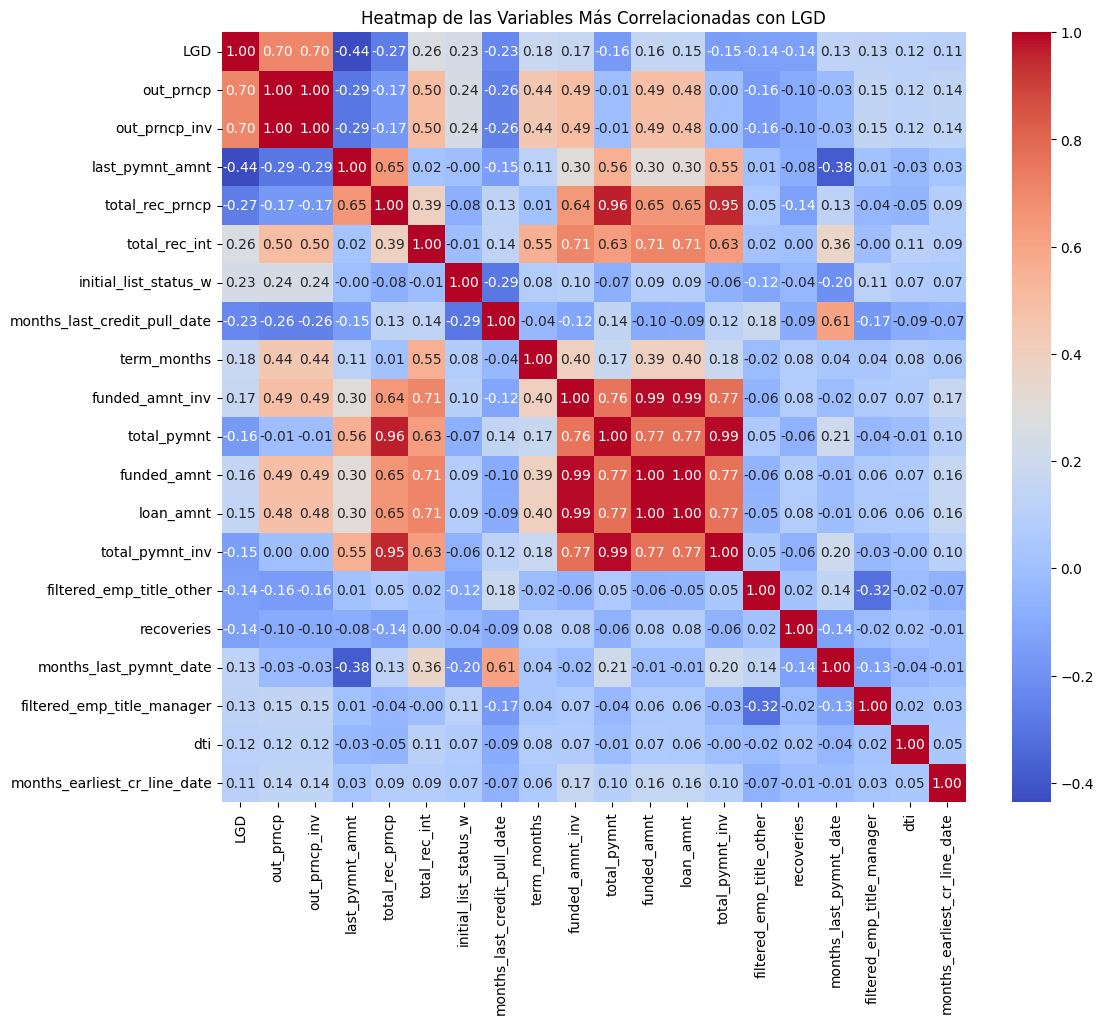

In [81]:

# Seleccionar las variables más correlacionadas (ajusta el número si es necesario)
top_n_corr = corr_cerrados.index[:20]  # Por ejemplo, las 20 más correlacionadas con LGD

# Filtrar el DataFrame original con las variables seleccionadas
filtered_corr = df_const_cerrados[top_n_corr].corr()

# Crear el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Heatmap de las Variables Más Correlacionadas con LGD')
plt.show()

**VARIABLES CATEGÓRICAS**

Sólo aplicamos este paso al conjunto de construcción de los procesos cerrados, que será el que vamoa a modelizar. Los otros 3 dataset son para predecir.

In [82]:
df_const_cerrados.dtypes

loan_amnt                        float64
funded_amnt                      float64
funded_amnt_inv                  float64
int_rate                         float64
installment                      float64
                                  ...   
filtered_emp_title_service          bool
filtered_emp_title_specialist       bool
filtered_emp_title_supervisor       bool
filtered_emp_title_teacher          bool
filtered_emp_title_technology       bool
Length: 76, dtype: object

1. Agrupar por Todas las Variables Categóricas y Calcular el Promedio de LGD

In [83]:
# Identificar las variables booleanas
boolean_vars = df_const_cerrados.select_dtypes(include=['bool', 'int']).columns  # Identificar booleanas y enteros (0/1)

# Crear un DataFrame con la media de LGD para True y False
results = {}
for var in boolean_vars:
    if var != 'LGD':  # Asegurarse de no incluir la variable objetivo
        results[var] = df_const_cerrados.groupby(var)['LGD'].mean()

# Convertir los resultados a un DataFrame
mean_lgd_df = pd.DataFrame(results)
mean_lgd_df.index = ['False', 'True']  # Añadir etiquetas de categorías


2. Transformar el DataFrame para Visualización Tipo Heatmap

In [84]:
heatmap_data = mean_lgd_df.T  # Transponer para que las variables sean filas

In [85]:
heatmap_data.shape

(35, 2)

3. Visualizar el Heatmap

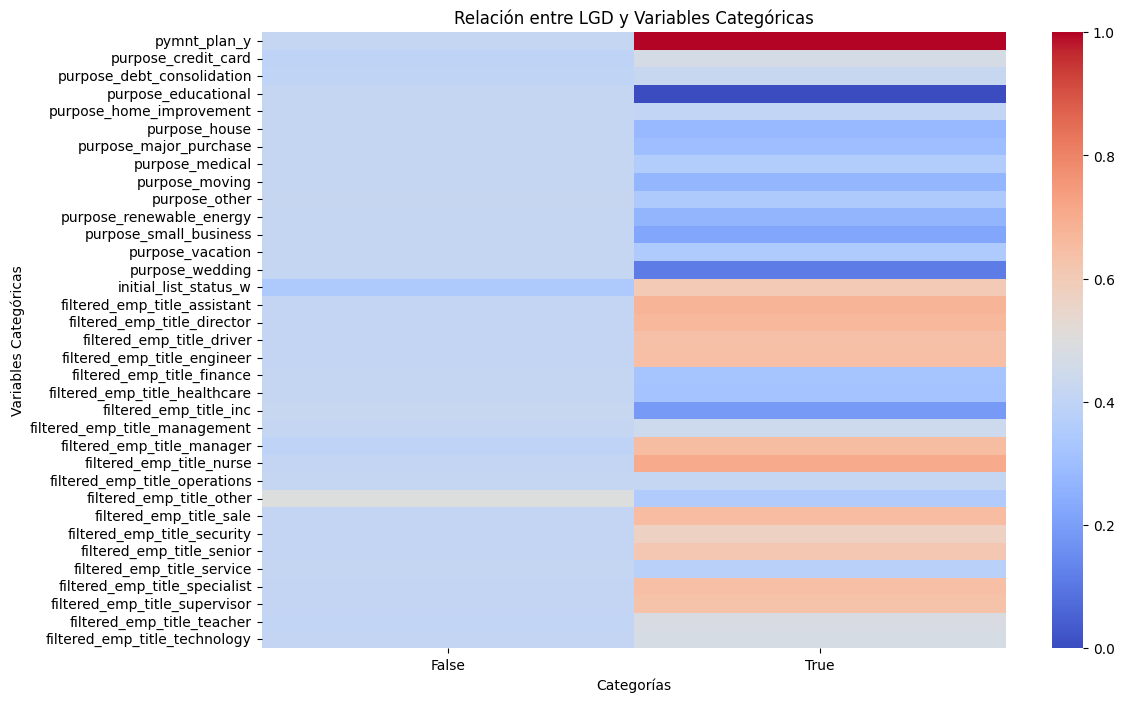

In [86]:
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', cbar=True)
plt.title('Relación entre LGD y Variables Categóricas')
plt.xlabel('Categorías')
plt.ylabel('Variables Categóricas')
plt.show()

#### <p style="color:blue;">5.6. GUARDAR DATASETS EN UN CSV</p>

In [87]:
df_explot_abiertos

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,filtered_emp_title_operations,filtered_emp_title_operator,filtered_emp_title_other,filtered_emp_title_ownership,filtered_emp_title_sales,filtered_emp_title_security,filtered_emp_title_senior,filtered_emp_title_specialist,filtered_emp_title_support,filtered_emp_title_technology
165139,0.529412,0.529412,0.529412,0.499732,0.336551,0.235501,0.546818,0.000000,0.0,0.205882,...,False,False,False,False,False,False,False,False,False,False
169151,0.264706,0.264706,0.263235,0.429031,0.246943,0.121265,0.987325,0.000000,0.0,0.441176,...,False,False,False,False,False,False,False,False,False,False
173000,0.323529,0.323529,0.323529,0.153187,0.278309,0.361453,0.240300,0.000000,0.2,0.382353,...,False,False,False,False,False,False,False,False,False,False
173300,0.558824,0.558824,0.558824,0.464381,0.527948,0.135911,0.671754,0.111111,0.6,0.558824,...,False,True,False,False,False,False,False,False,False,False
175486,0.383088,0.383088,0.383088,0.373326,0.352234,0.077329,0.490429,0.000000,0.0,0.794118,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400844,0.069118,0.069118,0.069118,0.357258,0.061778,0.045108,0.667356,0.000000,0.0,0.058824,...,False,False,False,False,False,False,False,False,True,False
401110,0.411765,0.411765,0.411765,0.179432,0.222860,0.097832,0.426539,0.111111,0.0,0.470588,...,False,False,True,False,False,False,False,False,False,False
401458,0.397059,0.397059,0.397059,0.446706,0.372936,0.150557,0.486808,0.000000,0.0,0.264706,...,False,False,False,False,False,False,False,False,False,False
401925,0.411765,0.411765,0.411765,0.062667,0.345627,0.267721,0.320228,0.000000,0.0,0.323529,...,False,False,False,False,False,False,False,False,False,False


In [88]:
df_const_cerrados.to_csv("df_const_cerrados_LGD.csv", index=False)
df_const_abiertos.to_csv("df_const_abiertos_LGD.csv", index=False)
df_explot_cerrados.to_csv("df_explot_cerrados_LGD.csv", index=False)
df_explot_abiertos.to_csv("df_explot_abiertos_LGD.csv", index=False)